<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/DLWeek7_2imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [ ]:
# Parameter
num_words = 30000
maxlen = 500

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


# RNN Model

RNN (Recurrent Neural Network) bekerja dengan menyimpan informasi dari time step sebelumnya:

### Rumus RNN:

**Hidden state:**
$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

**Output:**
$$
y_t = W_{hy}h_t + b_y
$$

- \( x_t \): input pada waktu ke-t
- \( h_t \): hidden state pada waktu ke-t
- \( W_{xh}, W_{hh}, W_{hy} \): bobot jaringan
- \( b_h, b_y \): bias
- \( \tanh \): fungsi aktivasi nonlinear

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=maxlen  # pastikan maxlen diset jika ada pad_sequences
    ))

    # Simpan jumlah layer
    num_layers = hp.Int('rnn_layers', 2, 5)

    # Loop RNN layer
    for i in range(num_layers):
        model.add(SimpleRNN(
            units=hp.Int(f'rnn_units_{i}', min_value=32, max_value=128, step=32),
            return_sequences=(i < num_layers - 1)
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())

    # Dense layer
    model.add(Dense(units=hp.Int('dense1', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = Adam(learning_rate=lr) if optimizer_choice == 'adam' else RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Hyperparameter Tuning

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='deep_rnn_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights
)

# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 07m 27s]
val_accuracy: 0.7134000062942505

Best val_accuracy So Far: 0.8745000064373016
Total elapsed time: 03h 55m 43s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 27 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Final Train dan Evaluasi

In [ ]:
history = best_model.fit(
    x_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Evaluasi akhir
score = best_model.evaluate(x_test, y_test, verbose=0)
print("Akurasi Training Akhir: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Akurasi Test Akhir: {:.2f}%".format(score[1] * 100))

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 243ms/step - accuracy: 0.9241 - loss: 0.2059 - val_accuracy: 0.8458 - val_loss: 0.4727
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 205ms/step - accuracy: 0.9476 - loss: 0.1473 - val_accuracy: 0.8304 - val_loss: 0.4252
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.9608 - loss: 0.1190 - val_accuracy: 0.8672 - val_loss: 0.3847
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.9750 - loss: 0.0777 - val_accuracy: 0.8828 - val_loss: 0.5899
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 203ms/step - accuracy: 0.9749 - loss: 0.0775 - val_accuracy: 0.8724 - val_loss: 0.5875
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.9818 - loss: 0.0596 - val_accuracy: 0.8498 - val_loss: 0.5851
Akurasi Training Akhir: 98.11%
Akurasi Test Akhir: 85.50%


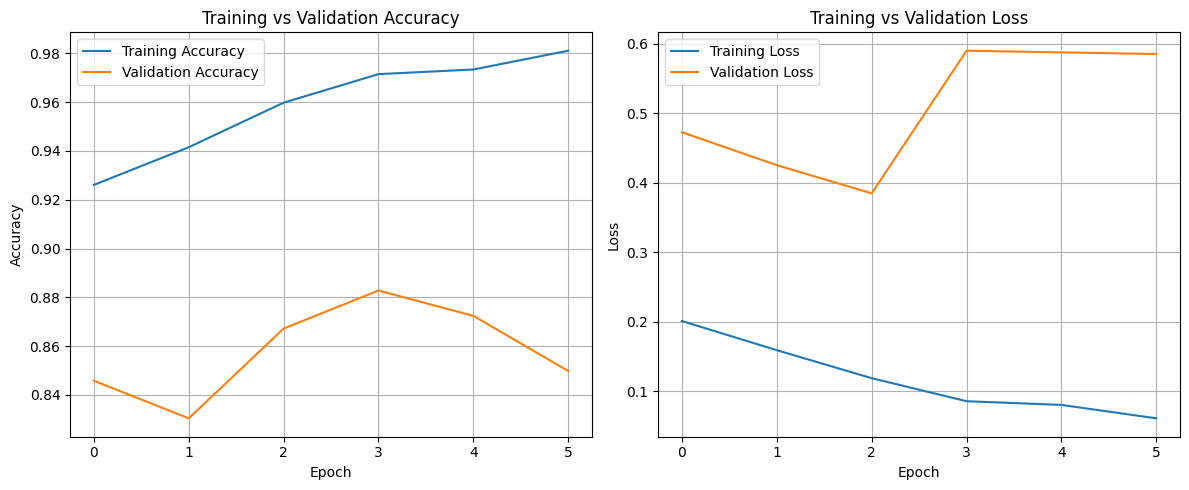

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85     12500
    Positive       0.83      0.90      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.85     25000
weighted avg       0.86      0.86      0.85     25000



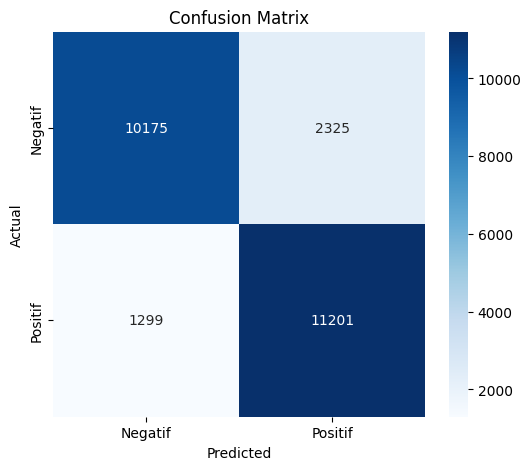

AUC Score: 0.9317


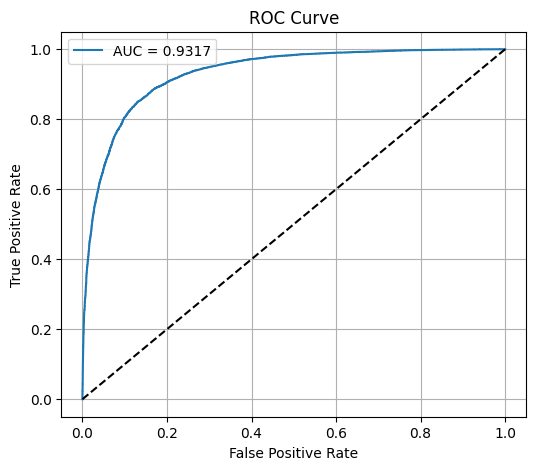

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi probabilitas & kelas
y_pred_proba = best_model.predict(x_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# === Evaluasi Metrik ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Persamaan Matematis

Metrik Evaluasi

### Accuracy
$$
\text{Accuracy} = \frac{\text{True Positives + True Negatives}}{\text{Total Samples}}
$$

### Precision
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### Recall
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### F1-Score
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### AUC (Area Under Curve)
Mengukur area di bawah kurva ROC. Semakin besar, semakin baik model membedakan antara kelas.

---

## 📈 ROC Curve
ROC (Receiver Operating Characteristic) menunjukkan trade-off antara True Positive Rate (TPR) dan False Positive Rate (FPR):

- TPR = Recall
- FPR = \( \frac{FP}{FP + TN} \)

Kurva ROC ideal berada di pojok kiri atas (TPR tinggi, FPR rendah).